In [1]:
import sys
import nltk
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from scipy.sparse import hstack
import re                                  
import string            
import scipy
from sklearn.model_selection import KFold, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegressionCV
import seaborn as sns
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer     
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer 


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 1. Load data

In [2]:
train_data = pd.read_csv('../input/quora/train.csv')
test_data = pd.read_csv('../input/quora/test.csv')
train_data.describe()

,target
count,783673.000000
mean,0.061826
std,0.240839
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [3]:
train=train_data.copy()
test=test_data.copy()
df=train.copy()

In [4]:
print(np.shape(train),np.shape(test))
train

(783673, 3) (522449, 2)


,qid,question_text,target
0,6f47b0f60633c2056455,"How can I reply to this comment, ""India is poo...",0
1,d49b3966070b27bf07fc,What did they use for transportation in Ancien...,0
2,6d5faa49380557c8ca7b,What are the most important provisions of Obam...,0
3,cebea75faa47388edcf5,At what age do most Finns master English today?,0
4,2a7b76a679cadb0a016e,What is cheapest place to live in India for on...,0
...,...,...,...
783668,8462d2ead608fe1dcf9b,What causes a lump on the back of your head?,0
783669,12d225a4e28317c02151,What is standalone in simple way?,0
783670,03edc045cadbb11558dd,How do you prevent having low potassium while ...,0
783671,c6fb7dc8d0b34160dbe4,What is it like to meet the band Imagine Dragons?,0


### 2. EDA

Here we tried to extract some features from data before preprocessing like no of lines,question marks,no of capital words etc.
And tried to plot correlation between them.

In [5]:
#count no of lines
df["count_lines"]=df["question_text"].apply(lambda x:len(re.findall("\n",str(x)))+1)
#count no of question marks
df["count_que_marks"]=df["question_text"].apply(lambda x:len(re.findall("\?",str(x)))+1)
#count no of words
df["count_words"]=df["question_text"].apply(lambda x:len(str(x).split()))
#number of unique words
df["count_unique_words"]=df["question_text"].apply(lambda x:len(set(str(x).split())))
#Letters
df["count_letters"]=df["question_text"].apply(lambda x:len(str(x)))
#capital words
df["count_words_uppercase"]=df["question_text"].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))
#howmany titles
df["count_words_titles"]=df["question_text"].apply(lambda x:len([w for w in str(x).split() if w.istitle()]))
#average word length
df["mean_word_len"]=df["question_text"].apply(lambda x:np.mean([len(w) for w in str(x).split()]))


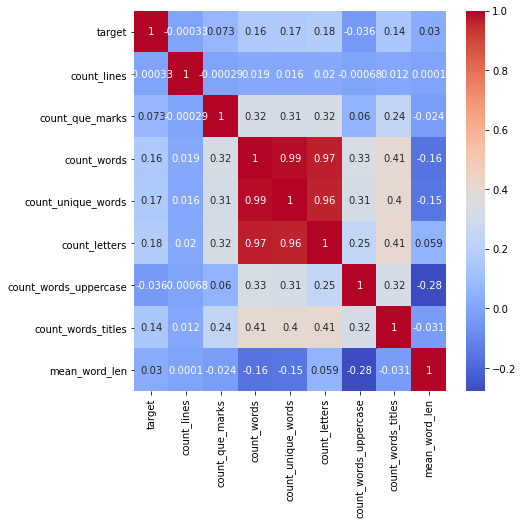

In [6]:
cor=df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(cor,annot=True,cmap="coolwarm")
plt.show()

From above plot it is clearly seen that there is not much correaltion between the target and extracted features. So we will not be including this features in our model.

In [7]:
train_data
actual_test=test_data.copy()
actual_test

,qid,question_text
0,f56a9a31974dc66186e8,Is it a good idea to go through a phlebotomy c...
1,d957c3758060f45da303,How can I fix a lead into a camlin compass to ...
2,ad822d5abaedb9e247b9,How many animes are there in world?
3,4e979c23eeb6a4bd1f2e,How do I tell my family I cut?
4,333cc031262566b8da49,How do I save down my bitcoin image address fr...
...,...,...
522444,e8e6aa5226f36c27fe41,"In terms of absolute passion and leadership, w..."
522445,015fd068afcb9d0b4007,How do I make my orthodox Indian parents accep...
522446,9f0ef49eff6a3ff9e735,How can air force officers go to ranger school?
522447,d6b02f52f76dc4c22afd,Why does my brothers cow kick me all the time?


In [8]:
#train-test split - train=0.8,test=0.2
train_df, test_df = train_test_split(train_data, test_size=0.2, random_state=2020)

In [9]:
train_df["target"].value_counts()

0    588066
1     38872
Name: target, dtype: int64

In [10]:
train,test = train_test_split(train_data, test_size=0.2)

In [11]:
train["target"].value_counts()

0    588172
1     38766
Name: target, dtype: int64

In [12]:
test["target"].value_counts()

0    147050
1      9685
Name: target, dtype: int64

In [13]:
train_sincere_que = train[train['target']==0]
train_insincere_que = train[train['target']==1]
train_sincere_que_count, train_insincere_que_count = train['target'].value_counts()
print(train_sincere_que_count)
print(train_insincere_que_count)

588172
38766


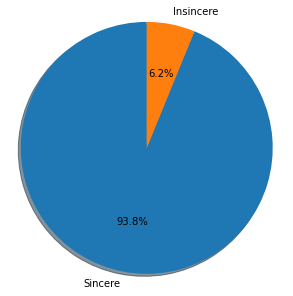

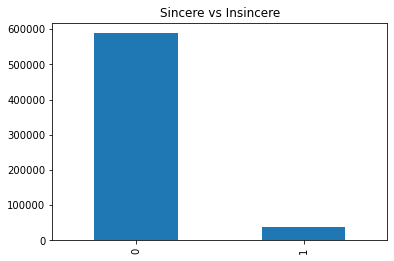

In [14]:
# Declare a figure with a custom size
fig = plt.figure(figsize=(5, 5))

labels = 'Sincere', 'Insincere'

sizes = [len(train_sincere_que), len(train_insincere_que)] 
plt.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.show()
train['target'].value_counts().plot.bar(title="Sincere vs Insincere")

As you can see Data is highly imbalanced.

### 4. Preprocessing

* Train -> Train_data(80%)
* Test -> Train_data(cross Validation data)(20%)
* TestA -> Actual test data

In [15]:
train_que = train['question_text']
test_que = test['question_text']
testA_que=actual_test['question_text']

In [16]:
# remove punctuations
train_que = train_que.str.replace(r'[^\w\d\s]', ' ')
test_que = test_que.str.replace(r'[^\w\d\s]', ' ')
testA_que = testA_que.str.replace(r'[^\w\d\s]', ' ')

# replace whitespace between terms with a single space
train_que = train_que.str.replace(r'\s+', ' ')
test_que = test_que.str.replace(r'\s+', ' ')
testA_que = testA_que.str.replace(r'\s+', ' ')

# remove leading and trailing whitespaces
train_que = train_que.str.replace(r'^\s+|\s+?$', '')
test_que = test_que.str.replace(r'^\s+|\s+?$', '')
testA_que = testA_que.str.replace(r'^\s+|\s+?$', '')

#removing numbers
train_que=train_que.apply(lambda x:re.sub('\d','',x))
test_que=test_que.apply(lambda x:re.sub('\d','',x))
testA_que=testA_que.apply(lambda x:re.sub('\d','',x))


In [17]:
#convert to lower case
train_que = train_que.str.lower()
test_que = test_que.str.lower()
testA_que = testA_que.str.lower()

In [18]:
#contraction
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }
def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text
train_que=train_que.apply(lambda x: clean_contractions(x, contraction_mapping))
test_que=test_que.apply(lambda x: clean_contractions(x, contraction_mapping))
testA_que=testA_que.apply(lambda x: clean_contractions(x, contraction_mapping))

In [19]:
train['clean_que'] = train_que
test['clean_que'] = test_que
actual_test['clean_que'] = testA_que
train.tail()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,qid,question_text,target,clean_que
763280,8b5c08026e07f06e4344,How can someone change your mind when you're a...,0,how can someone change your mind when you re a...
547552,60a3001dd486dda62004,What happens when throw water in extension?,0,what happens when throw water in extension
371374,59b4d7847750804a74f5,I am in the 2nd year of my graduation (B.A) I ...,0,i am in the nd year of my graduation b a i nee...
451896,93f6464040102d7942e1,Why do people appreciate Ye Jawani Hai Deewani...,0,why do people appreciate ye jawani hai deewani...
43521,63e833f99247b36f6c0b,Should Hindus in India start teaching Islam to...,0,should hindus in india start teaching islam to...


### 5. Feature selection

In [20]:
all_que = pd.concat([train_que, test_que,testA_que],axis=0)

print(all_que)

487559    what are some good dissertations thesis writte...
567923    which country has the hardest physics in their...
229953    is there any suggestions on buying concert tic...
18668     how does someone keep their children when they...
478633                      what is wrong with transgenders
                                ...                        
522444    in terms of absolute passion and leadership wh...
522445    how do i make my orthodox indian parents accep...
522446       how can air force officers go to ranger school
522447        why does my brothers cow kick me all the time
522448               how was japan s national animal chosen
Name: question_text, Length: 1306122, dtype: object


In [21]:
all_que.reset_index(inplace=True,drop=True)

In [22]:
print(all_que)

0          what are some good dissertations thesis writte...
1          which country has the hardest physics in their...
2          is there any suggestions on buying concert tic...
3          how does someone keep their children when they...
4                            what is wrong with transgenders
                                 ...                        
1306117    in terms of absolute passion and leadership wh...
1306118    how do i make my orthodox indian parents accep...
1306119       how can air force officers go to ranger school
1306120        why does my brothers cow kick me all the time
1306121               how was japan s national animal chosen
Name: question_text, Length: 1306122, dtype: object


In [23]:
word_vectorizer = TfidfVectorizer(
        sublinear_tf=True,
        strip_accents='unicode',
        analyzer='word',
        min_df=5,
        norm='l2',
        ngram_range=(1, 1),
        max_features=40000)

word_vectorizer.fit(all_que)
train_word_features = word_vectorizer.transform(train_que)
test_word_features = word_vectorizer.transform(test_que)
testA_word_features = word_vectorizer.transform(testA_que)

In [24]:
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    min_df=5,
    ngram_range=(2, 4),
    max_features=30000)

char_vectorizer.fit(all_que)
train_char_features = char_vectorizer.transform(train_que)
test_char_features = char_vectorizer.transform(test_que)
testA_char_features = char_vectorizer.transform(testA_que)

In [25]:
print(train_word_features.shape)
print(test_word_features.shape)
print(testA_word_features.shape)

(626938, 40000)
(156735, 40000)
(522449, 40000)


In [26]:
print(train_char_features.shape)
print(test_char_features.shape)
print(testA_char_features.shape)

(626938, 30000)
(156735, 30000)
(522449, 30000)


In [27]:
train_features = hstack([train_word_features,
                         train_char_features,
                        ]).tocsr()
test_features = hstack([test_word_features,
                        test_char_features,
                       ]).tocsr()
testA_features = hstack([testA_word_features,
                         testA_char_features,
                        ]).tocsr()

In [28]:
print(train_features.shape)
print(test_features.shape)
print(testA_features.shape)

(626938, 70000)
(156735, 70000)
(522449, 70000)


In [29]:
y=train.iloc[:]["target"]
print(y)

487559    0
567923    0
229953    0
18668     0
478633    1
         ..
763280    0
547552    0
371374    0
451896    0
43521     0
Name: target, Length: 626938, dtype: int64


In [30]:
print(train_features.shape)
print(test_features.shape)
print(testA_features.shape)
print(y.shape)

(626938, 70000)
(156735, 70000)
(522449, 70000)
(626938,)


## logisitic

This function will loop through the threshold values from 0.01 to 0.99 to find the threshold where we get maximum f1-score.

In [31]:
 def find_thresh(prediction_prob):
    max1=-1
    #scores=[]
    from sklearn import metrics
    for thresh in np.arange(0.1, 1, 0.01):
        thresh = np.round(thresh, 2)
        y1=[]
        for i in range(len(prediction_prob)):
            y1.append(0 if prediction_prob[i,1]<thresh else 1)
        s=metrics.f1_score(test["target"],y1)
        if s>max1:
            max1=s
            max_thresh=thresh
    print("F1 score at threshold {0} is {1}".format(max_thresh,max1))
    return max_thresh

Below is the manual grid search implementation for finding best C(regulizer) parameter value.

In [32]:
from sklearn.linear_model import LogisticRegression
c_values=[0.97,0.98]
for i in c_values:
    model=LogisticRegression(solver='lbfgs',
                             verbose=1,
                             C=i,n_jobs=-1)
    model.fit(train_features,y)
    prediction_prob=model.predict_proba(test_features)
    print("at c="+str(i))
    max_thresh=find_thresh(prediction_prob)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


at c=0.97
F1 score at threshold 0.25 is 0.6362045314791164


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


at c=0.98
F1 score at threshold 0.25 is 0.6361099285748072


### Here are some of our best cross validation score
* at c=0.95 F1 score at threshold 0.26 is 0.6362327188940091
* at c=0.96 F1 score at threshold 0.27 is 0.6369470102090422
* at c=0.97 F1 score at threshold 0.28 is 0.6356115816427024
* at c=0.98 F1 score at threshold 0.27 is 0.6362086600750086

In [33]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(#solver='saga',
                         verbose=1,
                         C=0.96,
                         solver='lbfgs', 
                         n_jobs=-1)
model.fit(train_features,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


LogisticRegression(C=0.96, n_jobs=-1, verbose=1)

In [34]:
prediction_prob=model.predict_proba(test_features)
predictionA_prob=model.predict_proba(testA_features)

max_thresh -> Threshold value where we got highest score.

In [35]:
max_thresh=find_thresh(prediction_prob)
max_thresh

F1 score at threshold 0.25 is 0.6358819076457229


0.25

Now we are predicting final prediction for test data such that it will be classified as 0 if probability < max_thresh else 1.

In [36]:
final_prediction=[]
for i in range(len(predictionA_prob)):
    final_prediction.append(0 if predictionA_prob[i,1]<max_thresh else 1)

In [37]:
submission = pd.DataFrame.from_dict({'qid': test_data['qid']})
submission['target'] = final_prediction

submission.to_csv('final_submission.csv', index=False)